# TILES
## Scraping play-by-play data from stats.nba.com

We define two methods, one using BeautifulSoup and the other using the stats.nba.com API (via http://www.gregreda.com/2015/02/15/web-scraping-finding-the-api/).

We use the API method.

The BeautifulSoup method is preserved for reference.

We use the EVENTMSGTYPE column because it encodes the action information. See DOCS.md for details.

## Method 2 - with stats.nba.com API

In [1]:
import sys
import requests
import pandas as pd
import numpy as np
from IPython.display import display, clear_output


# dont hide columns when displaying dataframe
pd.set_option('display.max_columns', None)

## Get the data

~~sometimes (often) the link does not open on the first try (a HTTP request exception is thrown)~~

~~a workaround is to open the link on the browser and then re-run~~

SOLVED: need to provide a user-agent

In [2]:
# get playbyplay data
# needs an internet connection

# playbyplay_url = 'http://stats.nba.com/stats/playbyplay?StartPeriod=1&EndPeriod=10&GameID=0041500314'
# alternative link: 'http://stats.nba.com/stats/playbyplayv2?StartPeriod=1&EndPeriod=10&GameID=0041500314' (more complete data, with player info)

base_pbp_url = 'http://stats.nba.com/stats/playbyplay?StartPeriod=1&EndPeriod=10&GameID='


# example: get gameIDs for all games of 2015/2016 regular season
from tilestools import get_gameID

games = []
season = 2015
typ = 'R'
total_games = 10

for num in range(1,total_games):
    gameid = get_gameID(season, typ, num)
    games.append(gameid)

# complete URL list

pbp_url_list = [base_pbp_url + gameid for gameid in games]


df_raw_list = [] 
j=0
for playbyplay_url in pbp_url_list:
    j+=1
    # request the URL and parse the JSON
    head = {'user-agent': 'Mozilla/5.0 (Windows NT 10.0; WOW64; rv:43.0) Gecko/20100101 Firefox/43.0'}
    response = requests.get(playbyplay_url, headers=head)
    response.raise_for_status() # raise exception if invalid response
    header = response.json()['resultSets'][0]['headers']
    plays = response.json()['resultSets'][0]['rowSet']

    # get the playbyplay data in a dataframe
    df_raw_list.append(pd.DataFrame(plays, columns=header))
    
    clear_output(wait=True)
    print("({}/{}) Acquired data from {}".format(j, len(pbp_url_list), playbyplay_url))
    sys.stdout.flush()

(9/9) Acquired data from http://stats.nba.com/stats/playbyplay?StartPeriod=1&EndPeriod=10&GameID=0021500009


We should find a way of storing all these game logs, to avoid being dependent on internet connection, the logs availability, etc

At least write them to CSV

In [3]:
# write acquired data to csv
# to use, set FLAG_write_to_csv to True

import os

FLAG_write_to_csv = False

if FLAG_write_to_csv is True:
    i=0
    basefolder = 'data/'
    for g in games:
        filename = g+'.csv'
        df_raw_list[i].to_csv(os.path.join(basefolder, filename))
        
        clear_output(wait=True)
        print("({}/{}) Write CSV file {}".format(i, len(games), filename))
        sys.stdout.flush()
        
        i+=1
        
else:
    print("No CSV files written (FLAG_write_to_csv set to False)")


No CSV files written (FLAG_write_to_csv set to False)


## Pre-processing data (including handling missing data)

In [4]:

# define features to consider

features = ["REBOUND_HOME", "REBOUND_AWAY", 
            "2PT_MADE_HOME", "2PT_MADE_AWAY",
            "2PT_MISS_HOME", "2PT_MISS_AWAY",
            "3PT_MADE_HOME", "3PT_MADE_AWAY",
            "3PT_MISS_HOME", "3PT_MISS_AWAY",
            "TOV_HOME", "TOV_AWAY",
            "TIMEOUT_HOME", "TIMEOUT_AWAY"
            ]



# set up master_X, master_y to aggregate information of each game
# later, these first lines ust be removed
master_X = np.ones((1,len(features)-2)) # -2 because of timeouts, which we don't include in X
master_y = np.ones(1)

# iterate over all games, which are stored in a list of dataframes
from tilestools import build_df_events, build_cumulative_data

j=0
for df_raw in df_raw_list:
    j+=1
    
    # create a copy
    df = df_raw.copy()

    # propagate score so that every table has the appropriate score

    # set first score to 0-0
    df.set_value(0,'SCORE',"0 - 0")
    # forward-propagate
    df.SCORE.fillna(method='ffill', inplace=True)


    # regularize eventnum (sometimes jumps a few)
    # make it match df lin
    df['EVENTNUM'] = pd.Series(df.index)


    # let's build a dataframe with only 0 and 1: df_events
    # each line is an event and is all zeros and only one 1, corresponding to the event 
    # df_events contains only events which are selected as relevant
    # refer to DOCS.md for documentation on how to deal with EVENTMSGTYPE and other features of original dataframe



    df_events = build_df_events(df, features)

    X, y = build_cumulative_data(df_events, window_size=20)





    # now we have a one-hot encoded dataframe where every row is an event and is all zeros except for one column,
    #     which corresponds to the event
    # must decide what to to with rows that are not featured events!

#    print("All zero rows: {}/{}".format((df_events==0).all(axis=1).sum(), len(df_events)))


    master_X = np.concatenate((master_X, X))
    master_y = np.concatenate((master_y, y))

    clear_output(wait=True)
    print("({}/{}) Size of X: {} % of timeout events: {:.3f}%".format(j,len(df_raw_list), len(master_X), 100*sum(master_y==1)/len(master_X)))
    sys.stdout.flush()


(9/9) Size of X: 4136 % of timeout events: 2.611%


In [5]:
# restore natural nomenclature, deleting first line
    
X = master_X[1:]
y = master_y[1:]

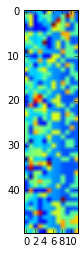

In [27]:
## Visualizing X
## select N random training examples to visualize

N = 50

idx = np.random.choice(range(len(X)), size=N, replace=False)
plt.imshow(X[idx])

107

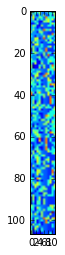

In [38]:
## Visualize X when it's a timeout event

idx = y==1
plt.imshow(X[idx])

sum(idx)

# need more timeouts! this should show some structure!!!!!

## Learning

First we must set up cross-validation to understand how our model is performing.

Because we have very skewed data, i.e. many examples of one class (non-timeout) and few of the other (timeout), we cannot simply randomly split the data into training and test sets because we run the risk of putting very few (or none at all) positive examples in one of the sets.

To address this problem we do something called stratified sampling, which simply means selecting data points randomly but preserving the relative class frequencies.

So for example, say we have 1000 data points where 10 are positive examples and 990 are negative examples. We want to split the data in 80% training and 20% test data. Then what we do is we randomly select 80% of the 990 negative examples, plus 80% of the 10 positive example, and that is our training set; the remaining 20% of the 990 negative examples plus 20% of the 10 positive examples are our test set.

This we we at least ensure we're not making the problem of over-representation of one class even worse.

In [8]:
# let's start by standardizing our features

from sklearn.preprocessing import StandardScaler

# standardize features
sc = StandardScaler(copy=False)
sc.fit_transform(X);

In [9]:
# we'll split our data in 80-20 fashion
# because we're dealing with skewed classes, must use stratified sampling
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.20, stratify=y)


In [11]:

scores = []

for K in range(30):


    # we'll split our data in 80-20 fashion
    # because we're dealing with skewed classes, must use stratified sampling
    from sklearn.cross_validation import train_test_split

    X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.20, stratify=y)


    # let's try oversampling X, i.e. repeating the timeout data points
    # we'll do this up to a point where we get a 90-10 imbalance
    # since we start with about 2.5% positive y, 

    positive_X = X_train[y_train==1]
    positive_y = y_train[y_train==1]

    positive_y.shape

    new_X_train = X_train.copy()
    new_y_train = y_train.copy()

    addons = K
    for i in range(0,addons):
        new_X_train = np.concatenate((new_X_train,positive_X))
        new_y_train = np.concatenate((new_y_train,positive_y))

    X_train=new_X_train
    y_train=new_y_train

    from sklearn.linear_model import LogisticRegression

    # fit model
    model = LogisticRegression()
    model.fit(X_train,y_train);

    y_test_predicted = model.predict(X_test)

    from tilestools import F1score
    f1 = F1score(y_test, y_test_predicted)
    
    scores.append((K,f1))

/Users/joaopcoelho/anaconda/envs/python3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


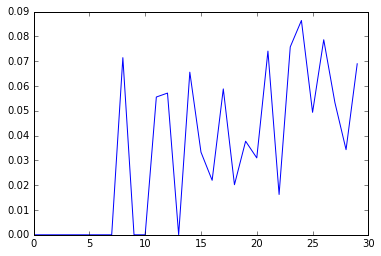

In [12]:
plt.plot(*zip(*scores))

In [14]:
X_train=new_X_train
y_train=new_y_train

from sklearn.linear_model import LogisticRegression

# fit model
model = LogisticRegression()
model.fit(X_train,y_train);

y_test_predicted = model.predict(X_test)

from tilestools import F1score
F1score(y_test, y_test_predicted)

0.068965517241379309

Let's train our first model - Logistic regression

In [16]:
from sklearn.linear_model import LogisticRegression

# fit model
model = LogisticRegression()
model.fit(X_train,y_train);

y_test_predicted = model.predict(X_test)

from tilestools import F1score
F1score(y_test, y_test_predicted)

0.068965517241379309

Cool, let's see training and test scores (mean accuracy)


In [17]:
print(model.score(X_train,y_train))
print(model.score(X_test, y_test))


0.617718028266
0.738814993954


Hey, looks pretty good!

Wait a minute... 

In [18]:
y_train_predicted = model.predict(X_train)
y_test_predicted = model.predict(X_test)
print(y_test_predicted)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  1.  0.
  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.  0.
  0.  0.  1.  0.  1.  1.  1.  0.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.  0.
  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.  0.  1.  1.  0.  0.  0.  0.  1.
  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
  0.  1.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.
  1.  0.  0.  0.  1.  0.  0.  0.  1.  1.  0.  0.  0

Ok so this model is just predicting zeros for everything. Not very useful

We can use precision and recall to better evaluate its performance

Could we also train it to optimize these costs, rather than the typical logloss?

In [19]:
# use precision and recall metrics
from sklearn.metrics import precision_score, recall_score


precision_train = precision_score(y_train, y_train_predicted)
recall_train = recall_score(y_train, y_train_predicted)

precision_test = precision_score(y_test, y_test_predicted)
recall_test = recall_score(y_test, y_test_predicted)


print ("Train: ", precision_train, recall_train)
print ("Test: ", precision_test, recall_test)

Train:  0.588812561335 0.46511627907
Test:  0.0379146919431 0.380952380952


In [20]:
# use F1-score
# from now on, this is what we'll use to evaluate models

from tilestools import F1score
F1score(y_test, y_test_predicted)

# what does this score mean? we should at least be able to compare it to a random predictor or a always-zero predictor

0.068965517241379309

Well, shit.



So, where to go now:

1. ~~We clearly need more data - get data from other games~~ DONE
2. ~~We clearly need better data - separate features into for and against~~ DONE
3. We probably need a better model - would be nice to train with precision/recall rather than accuracy
4. Also, we can try under-sampling and over-sampling!

# Reference code

Code not used

## Method 1 - with BeautifulSoup
Not used


In [ ]:
# get all the info in the website, via inspecting the html code
# not used 

from bs4 import BeautifulSoup
import requests

import pandas as pd

url = "http://stats.nba.com/game/#!/0041500314/playbyplay/"
r  = requests.get(url)

data = r.text
soup = BeautifulSoup(data)
#print(soup.prettify())

table = soup.find('table', attrs={'class': "table"})
#print(table)


rows = table.findAll('tr')
for tr in rows:
    cols = tr.findAll('td')
    for td in cols:
        text = td.find(text=True) + ';'
#        print (text)


In [ ]:
# timeouts baby

df_home  = df[df.HOMEDESCRIPTION.notnull()]
df_home_timeouts=df_home[df_home.HOMEDESCRIPTION.str.contains("Timeout")]

df_away  = df[df.VISITORDESCRIPTION.notnull()]
df_away_timeouts=df_away[df_away.VISITORDESCRIPTION.str.contains("Timeout")]

In [ ]:
total_timeouts = pd.concat([df_home_timeouts, df_away_timeouts])

In [ ]:
total_timeouts.sort_values(by="EVENTNUM")[["EVENTMSGTYPE", "HOMEDESCRIPTION", "VISITORDESCRIPTION", "SCORE"]]

In [ ]:
# Explore data
# fields to explore: EVENTMSGACTIONTYPE, EVENTMSGTYPE

field_to_explore = "EVENTMSGTYPE"
fields_to_show = [field_to_explore] + ["EVENTMSGACTIONTYPE", "HOMEDESCRIPTION", "NEUTRALDESCRIPTION", "VISITORDESCRIPTION"]

a = df[fields_to_show]

max_ = df[field_to_explore].max()

from ipywidgets import interact

n=1
@interact(emat = (0,int(max_)))
def show_df(emat=n):
    display(a[a[field_to_explore] == emat])
